In [1]:
pip install pystan

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pystan

In [3]:
import pandas as pd
import numpy as np

In [ ]:
# In-house repo
from machine_learning.ml_utils.feature_extractor.feature_matrix import FeatureExtractor
from machine_learning.ml_utils.ts_cross_validation.tsc import ExpandingCrossValidator 
from machine_learning.ml_utils.returns.returns import calc_future_returns
from machine_learning.ml_utils.predict_collectors import PredictionsCollector
from machine_learning.ml_utils import helpers

In [6]:
import os
import sys
import datetime as dt
import pandas as pd
import numpy as np

# In[2]:

import multiprocessing as mp

import matplotlib.pyplot as plt
import pickle
# import pyarrow

In [7]:
import glob

In [5]:
start_data_date = '2000-01-01'
end_data_date = '2015-12-31'

In [ ]:
output_dir = '/media/farmshare2/Research/anthonyk/spark_bayesian/ML2_testoo/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define the Output Directory for each Training Period
output_path_period = output_dir + '/training-period_{}'
if not os.path.exists(output_path_period):
    os.makedirs(output_path_period)

output_path_plots = output_path_period + '/plots'
if not os.path.isdir(output_path_plots):
    os.mkdir(output_path_plots)

In [99]:
features_data_path = '/media/farmshare2/Research/FEATURE_ENGINEERING/SI_FCF/2000_2018/ranked'

pool_data_path = '/media/farmshare2/_PoolDump/RUSSELL3000_CONSOLIDATED/DATA-625/20190415/2000_2018/LATEST'

returns_data_path = '/media/farmshare2/_PoolDump/RUSSELL3000_CONSOLIDATED/DATA-625/20190415/2000_2018/LATEST/FWDReturns'


pool_indicators_path = '{}/_poolIndicatorF.csv'.format(pool_data_path)

feature_map = {
    'SI': '{}/RS3K_SI_TRUNC20_PR_NoFF.csv'.format(features_data_path),
    'FCF': '{}/RS3K_FCFoMCap_TRUNC80_PR_EVENT.csv'.format(features_data_path),
    'Beta' : '{}/_BR_BetaVsRUSSELL3000_Fast_ReleasedF.csv'.format(pool_data_path),
    'Group_val' : '/media/farmshare2/_PoolDump/RUSSELL3000_CONSOLIDATED/DATA-625/20190415/2000_2018/MISC/MktCapLabels/_marketCapCategory.csv'
}


target_map = {
    'FWD_Alpha-MCWTR-BrBetaR3KFast_O2O_W60': '{}/FWD_Alpha-MCWTR-BrBetaR3KFast_O2O_W60.csv'.format(
        returns_data_path)
}

# Preparing the feature and target data


pool_indicator = pd.read_csv(pool_indicators_path, index_col=0, parse_dates=True)


features = helpers.load_data_map(feature_map, pool_indicator, start_data_date, end_data_date)


target_dict = helpers.load_data_map(target_map, pool_indicator, start_data_date, end_data_date)


In [100]:
target_dict['FWD_Alpha-MCWTR-BrBetaR3KFast_O2O_W60'] = target_dict[
    'FWD_Alpha-MCWTR-BrBetaR3KFast_O2O_W60'].shift(-1)

In [101]:
horizon_days = 60
is_open_next_day = True
train_test_gap = horizon_days + (1 if is_open_next_day else 0)

feature_extractor = FeatureExtractor(features,
                                     target=target_dict['FWD_Alpha-MCWTR-BrBetaR3KFast_O2O_W60'],
                                     target_name='FWD_Alpha-MCWTR-BrBetaR3KFast_O2O_W60')

model_config = {
    'retrain_rate_days' : 130,
    'min_training_days' : 750,
    'train_test_gap' : train_test_gap
}

# Defining the Stan Model

INFO:machine_learning:The count of features data points BEFORE dropping NA: FWD_Alpha-MCWTR-BrBetaR3KFast_O2O_W60     7902523
SI                                        8294431
FCF                                        121392
Beta                                      8476905
Group_val                                11958561
dtype: int64
INFO:machine_learning:The count of features data points AFTER dropping NA: FWD_Alpha-MCWTR-BrBetaR3KFast_O2O_W60    112927
SI                                       118971
FCF                                      118971
Beta                                     118971
Group_val                                118971
dtype: int64


In [102]:
model_name = 'Complex_Model'
sampling_rate = 0.2  # 0.15
#num_samples = 400
group_indicator = 'None'
num_iterations = 300  # 500
num_chains = 1 # 7

In [103]:
ts_index = pool_indicator.index.values
# Needs to be re-initilized every run!
ts_generator = ExpandingCrossValidator(ts_index,
                                        return_index=False, **model_config)

# Class to store and process all predictions. The class needs to be reset every run!
prediction_collector = PredictionsCollector()


In [104]:
model_data = {}
score_array = []

#This is the loop which will need to get sparkified 
for idx, (train_interval, val_interval) in enumerate(ts_generator):

    start_t, end_t = helpers.get_ts_range(train_interval)
    print('Train range: Start={}/End={}'.format(start_t, end_t))
    start_v, end_v = helpers.get_ts_range(val_interval)
    print('Validate range: Start={}/End={}'.format(start_v, end_v))

    print('Extracting training data...')
    X_train, y_train, index_train = (
        feature_extractor.get_slice(datetime_range=train_interval))
    print(X_train.shape)

    print('Extracting testing data...')
    X_val, y_val, index_val = (
        feature_extractor.get_slice(datetime_range=val_interval))
    

Train range: Start=2005-01-11/End=2007-08-31
Validate range: Start=2007-11-27/End=2008-05-26
Extracting training data...
(29102, 4)
Extracting testing data...
Train range: Start=2005-01-11/End=2008-02-29
Validate range: Start=2008-05-27/End=2008-11-24
Extracting training data...
(33372, 4)
Extracting testing data...
Train range: Start=2005-01-11/End=2008-08-29
Validate range: Start=2008-11-25/End=2009-05-25
Extracting training data...
(39804, 4)
Extracting testing data...
Train range: Start=2005-01-11/End=2009-02-27
Validate range: Start=2009-05-26/End=2009-11-23
Extracting training data...
(44132, 4)
Extracting testing data...
Train range: Start=2005-01-11/End=2009-08-28
Validate range: Start=2009-11-24/End=2010-05-24
Extracting training data...
(50353, 4)
Extracting testing data...
Train range: Start=2005-01-11/End=2010-02-26
Validate range: Start=2010-05-25/End=2010-11-22
Extracting training data...
(54629, 4)
Extracting testing data...
Train range: Start=2005-01-11/End=2010-08-27
V

In [105]:
feature_names = list(feature_extractor.feature_names)

In [106]:
feature_names

['SI', 'FCF', 'Beta', 'Group_val']

In [107]:
stan_model = """
data {
       int<lower=0> N;                 //samples size
       int<lower=0> K;                 //number of parameters
       int<lower=0> T;                 //number of groups
       int<lower=1> idx_array[N];      //group index 
       matrix[N, K] X;
       vector[N] Y;
   }

   parameters {
       corr_matrix[K] Omega;
       vector<lower=0>[K] tau;
       vector[K] gamma;
       vector[K] coefs[T];
       real<lower=0,upper=100> sigma[T];
       real<lower=1,upper=20> nu[T];
   }

   model {
       tau ~ cauchy(0, 2.5);                                          //coefs share prior spread (i.e are pooled)
       Omega ~ lkj_corr(2);
       gamma ~ normal(0, 1.0);                                                      //coefs share prior location 
       for (t in 1:T)
            coefs[t] ~  multi_normal(gamma, quad_form_diag(Omega, tau));

       sigma ~ uniform(0, 100);                                                 //nuisance parameters are not pooled  
       nu ~ uniform(1, 20);

       for (i in 1:N)
            Y[i] ~ student_t(nu[idx_array[i]], X[i] * coefs[idx_array[i]] , sigma[idx_array[i]]);
   }
   """

In [108]:
X_train = X_train[~pd.isnull(y_train)]
y_train = y_train[~np.isnan(y_train)]

In [110]:
# Sampling the training set
sampling_index = range(X_train.shape[0])
np.random.seed(2019)
sampling_index = np.random.choice(sampling_index, replace=False, size=int(len(sampling_index) * sampling_rate))

X_train = X_train[sampling_index, :]
y_train = y_train[sampling_index]
index_train = index_train.iloc[sampling_index]

In [111]:
feature_names = list(feature_extractor.feature_names)

In [113]:
groups = np.sort(np.unique(X_train[:, feature_names.index('Group_val')]))

dict1 = dict(zip(groups, range(len(groups))))

T = len(groups)

idx_array = [dict1[x] for x in X_train[:, feature_names.index('Group_val')]]

In [114]:
#dropping group column
X_design = X_train.copy()
X_design = np.delete(X_design, feature_names.index('Group_val'), axis = 1)

#adding column for intercepts
X_design = np.c_[np.array([1]*X_design.shape[0]), X_design]

In [115]:
feature_names

['SI', 'FCF', 'Beta', 'Group_val']

In [ ]:
X_train

In [ ]:
X_design

In [ ]:
y_train

In [116]:
model_data_dict = {'N': X_design.shape[0],
               'K' : X_design.shape[1],
               'T' : T,
               'idx_array' : np.array(idx_array) + 1,
               'X' : X_design,
               'Y': y_train}


In [117]:
stan_model = pystan.StanModel(model_code=stan_model, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_41d45a0be48cd3b0218e7f5c192ea7e6 NOW.
INFO:pystan:OS: linux, Python: 3.6.7 | packaged by conda-forge | (default, Jul  2 2019, 02:18:42) 
[GCC 7.3.0], Cython 0.29.13
/home/researcher/anthonyk/bayesian/phra-spark-runner/venv/lib/python3.6/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpqw3xqnhp/stanfit4anon_model_41d45a0be48cd3b0218e7f5c192ea7e6_6073163926628016524.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Compiling /tmp/tmpqw3xqnhp/stanfit4anon_model_41d45a0be48cd3b0218e7f5c192ea7e6_6073163926628016524.pyx because it changed.
[1/1] Cythonizing /tmp/tmpqw3xqnhp/stanfit4anon_model_41d45a0be48cd3b0218e7f5c192ea7e6_6073163926628016524.pyx
building 'stanfit4anon_model_41d45a0be48cd3b0218e7f5c192ea7e6_6073163926628016524' extension
creating /tmp/tmpqw3xqnhp/tmp
creating /tmp/tmpqw3xqnhp/tmp/tmpqw3xqnhp
/home/researcher/anthonyk/bayesian/phra-spark-runner/venv/bin/x86_64-conda_cos6-linux-gnu-cc -DNDEBUG -fwrapv -O2 -Wall -Wstrict-prototypes -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/tmpqw3xqnhp -Ibayesian/phra-spark-runner/venv/lib/python3.6/site-packages/pystan -I/home/researcher/anthonyk/bayesian/phra-spark-runner/venv/lib/python3.6/site-packages/pystan -I/home/researcher/anthonyk/bayesian/phra-spark-runne

In [118]:
model_fit = stan_model.sampling(data=model_data_dict, iter=num_iterations, chains=num_chains)

In [26]:
output_dir

'/media/farmshare2/Research/anthonyk/spark_bayesian/ML2_testoo/'

In [119]:
parameter_samples = model_fit.extract(permuted=True)

# Saving The Output of Model

In [120]:
parameter_name

'lp__'

In [121]:
parameter_samples['tau'].shape

(150, 4)

In [122]:
parameter_samples['coefs'][:,:,3].shape

(150, 3)

In [123]:
parameter_samples['nu'].shape

(150, 3)

In [ ]:
model_fit.plot(pars=[parameter_samples['sigma']])

In [45]:
parameter_samples['coefs'].shape

(150, 3, 4)

In [ ]:
groups

In [50]:
['intercept'] + feature_names

['intercept', 'SI', 'FCF', 'Beta', 'Group_val']

In [ ]:
X_design

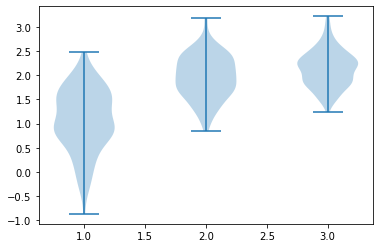

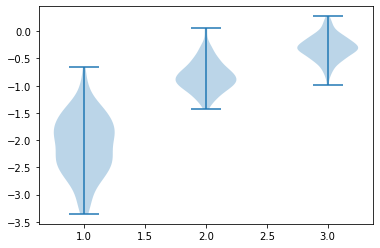

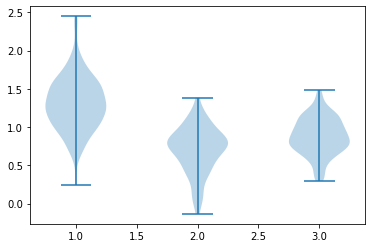

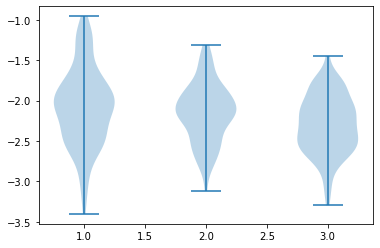

In [124]:
for j in [0,1,2,3]:
    plt.figure()
    plt.violinplot((parameter_samples['coefs'][:,:,j]))

In [69]:
A = parameter_samples['Omega'][1]
for j in range(1,50):
    A += parameter_samples['Omega'][j]

In [74]:
A*(1.0/50)

array([[ 1.        ,  0.02067873, -0.02361633, -0.05964348],
       [ 0.02067873,  1.        , -0.07775111,  0.06152801],
       [-0.02361633, -0.07775111,  1.        , -0.1182265 ],
       [-0.05964348,  0.06152801, -0.1182265 ,  1.        ]])

<Figure size 432x288 with 0 Axes>

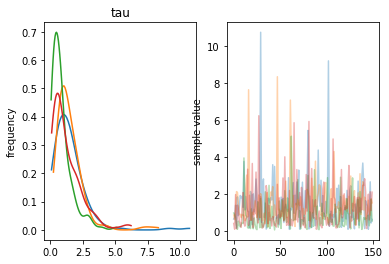

<Figure size 432x288 with 0 Axes>

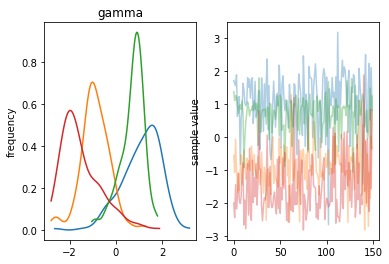

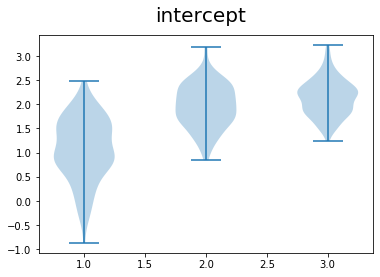

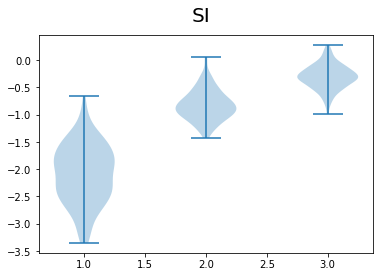

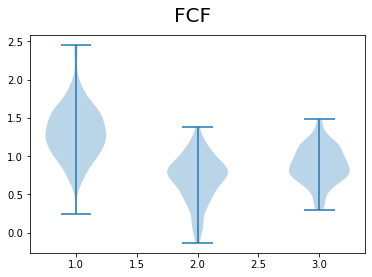

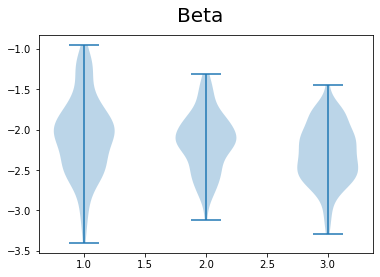

<Figure size 432x288 with 0 Axes>

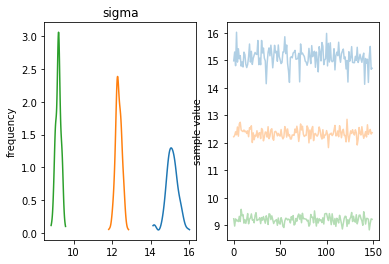

<Figure size 432x288 with 0 Axes>

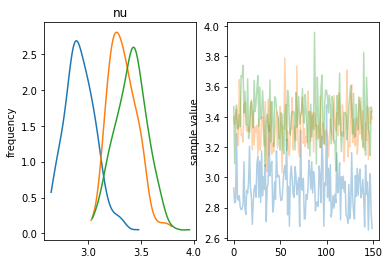

<Figure size 432x288 with 0 Axes>

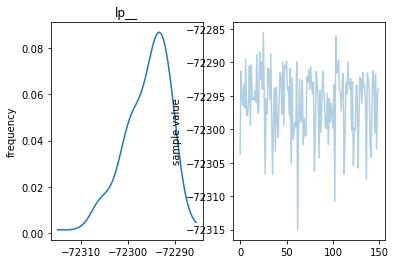

In [125]:
for parameter_name in parameter_samples.keys():
    if parameter_name == 'Omega':
        continue
    if parameter_name == 'coefs':
        for idx, x in enumerate(['intercept'] + feature_names[:-1]):
            plt.figure()
            plt.violinplot((parameter_samples['coefs'][:,:,idx]))
            plt.suptitle(x, fontsize=20)
    else:
        plt.figure()
        model_fit.plot(pars=[parameter_name])

In [78]:
parameter_samples['coefs'].shape

(150, 3, 4)

In [80]:
['intercept'] + feature_names

['intercept', 'SI', 'FCF', 'Beta', 'Group_val']

In [83]:
coef_dict = dict(zip(['intercept'] + feature_names[:-1], range(X_design.shape[1])))

In [126]:
X_val_df = pd.DataFrame(X_val, columns=feature_names)

In [135]:
scores = X_val_df.apply(
    lambda x: pd.Series(parameter_samples['coefs'][:, dict1[x['Group_val']], coef_dict['intercept']] +
                        x['SI'] * parameter_samples['coefs'][:, dict1[x['Group_val']], coef_dict['SI']] +
                        x['FCF'] * parameter_samples['coefs'][:, dict1[x['Group_val']], coef_dict['FCF']] +
                        x['Beta'] * parameter_samples['coefs'][:, dict1[x['Group_val']], coef_dict['Beta']]), axis=1)

In [132]:
scores = pd.concat([index_val, scores], axis=1)

In [133]:
scores.columns = ['t()', 'Ticker'] + list(map(str, scores.columns[2:]))

In [ ]:
parameter_samples = model_fit.extract(permuted=True)

In [ ]:
X_val_df = pd.DataFrame(X_val, columns=feature_names)

scores = X_val_df.iloc[:100,:].apply(lambda x: pd.Series(
    (parameter_samples['gamma00'] + parameter_samples['gamma01']*x['Group_val'] + np.random.normal(0,1, len(parameter_samples['gamma00']))) +
    x['FCF']*(parameter_samples['gamma10'] + parameter_samples['gamma11']*x['Group_val'] + np.random.normal(0,1, len(parameter_samples['gamma00'])))), axis = 1)

In [ ]:
#dropping group column
X_design_test = X_train.copy()
X_design = np.delete(X_design, feature_names.index('Group_val'), axis = 1)

#adding column for intercepts
X_design = np.c_[np.array([1]*X_design.shape[0]), X_design]